In [1]:
import sys
import torch
import pandas as pd
sys.path.append('..')

from uncertain.models import ExplicitMF, CPMF, OrdRec, GMF, GaussianGMF
from uncertain.datasets.movielens import get_movielens_dataset
from utils import train_test

from matplotlib import pyplot as plt
from matplotlib.colors import BASE_COLORS

results = {}
ML = get_movielens_dataset(variant='100K')
train, val, test = ML.split(test_percentage=0.1, validation_percentage=0.1, seed=0)
train, val, test

(<Explicit interactions (944 users x 1683 items x 79619 interactions)>,
 <Explicit interactions (944 users x 1683 items x 10439 interactions)>,
 <Explicit interactions (944 users x 1683 items x 9942 interactions)>)

# ExplicitMF (FunkSVD)

In [2]:
model = ExplicitMF(interactions=train, embedding_dim=50, lr=1e-3, batch_size=512, weight_decay=0)
results['ExplicitMF'] = train_test(model, train, val, test, max_k=10); results['ExplicitMF']

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_embeddings | ScaledEmbedding | 47.2 K
1 | item_embeddings | ScaledEmbedding | 84.2 K
----------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

{'RMSE': 0.9539099931716919,
 'Precision': tensor([0.0424, 0.0371, 0.0353, 0.0337, 0.0320, 0.0304, 0.0294, 0.0304, 0.0300,
         0.0291], dtype=torch.float64),
 'Recall': tensor([0.0074, 0.0124, 0.0169, 0.0211, 0.0255, 0.0285, 0.0317, 0.0367, 0.0408,
         0.0427]),
 'NDCG': tensor([0.0424, 0.0522, 0.0642, 0.0746, 0.0829, 0.0894, 0.0963, 0.1060, 0.1131,
         0.1180], dtype=torch.float64),
 'AUC': 0.7179342342651989}

# CPMF

In [3]:
model = CPMF(interactions=train, embedding_dim=50, lr=1e-3, batch_size=512, weight_decay=0)
results['CPMF'] = train_test(model, train, val, test, max_k=10); results['CPMF']

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_embeddings | ScaledEmbedding | 47.2 K
1 | item_embeddings | ScaledEmbedding | 84.2 K
2 | user_gammas     | ScaledEmbedding | 944   
3 | item_gammas     | ScaledEmbedding | 1.7 K 
4 | var_activation  | Softplus        | 0     
----------------------------------------------------
133 K     Trainable params
0         Non-trainable params
133 K     Total params
0.536     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

{'RMSE': 0.9664896726608276,
 'RPI': 0.2789763808250427,
 'Classification': 0.5500842281026275,
 'Correlation': {'Pearson': 0.09535641223192215,
  'Spearman': 0.08296018838882446},
 'Quantile RMSE': tensor([0.9835, 0.8502, 0.9004, 0.9220, 0.9142, 0.9438, 0.9124, 0.9201, 0.9514,
         0.9163, 0.9183, 0.8864, 0.9862, 0.9771, 0.9661, 1.0348, 1.0249, 1.0607,
         1.0689, 1.1411]),
 'Precision': tensor([0.0148, 0.0148, 0.0141, 0.0146, 0.0140, 0.0140, 0.0141, 0.0148, 0.0152,
         0.0151], dtype=torch.float64),
 'Recall': tensor([0.0022, 0.0040, 0.0055, 0.0080, 0.0100, 0.0120, 0.0140, 0.0163, 0.0196,
         0.0213]),
 'NDCG': tensor([0.0148, 0.0203, 0.0249, 0.0311, 0.0348, 0.0389, 0.0439, 0.0494, 0.0541,
         0.0579], dtype=torch.float64),
 'RRI': tensor([-0.1723, -0.1608, -0.1719, -0.1823, -0.2093, -0.2006, -0.2107, -0.2336,
         -0.2182]),
 'AUC': 0.6740032415564566}

# GaussianGMF

In [4]:
model = GaussianGMF(interactions=train, embedding_dim=50, lr=1e-3, batch_size=512, weight_decay=0)
results['GaussianGMF'] = train_test(model, train, val, test, max_k=10); results['GaussianGMF']

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_embeddings | ScaledEmbedding | 47.2 K
1 | item_embeddings | ScaledEmbedding | 84.2 K
2 | var_activation  | Softplus        | 0     
3 | linear          | Linear          | 100   
----------------------------------------------------
131 K     Trainable params
0         Non-trainable params
131 K     Total params
0.526     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

{'RMSE': 0.9750789999961853,
 'RPI': 0.690021276473999,
 'Classification': 0.6381849004907038,
 'Correlation': {'Pearson': 0.22338570654392242,
  'Spearman': 0.2183527797460556},
 'Quantile RMSE': tensor([0.6284, 0.7113, 0.7200, 0.7662, 0.8725, 0.8122, 0.8138, 0.8765, 0.9327,
         1.1067, 0.9661, 1.0230, 1.0082, 1.0752, 1.0859, 1.1484, 1.1134, 1.1203,
         1.1470, 1.2666]),
 'Precision': tensor([0.0382, 0.0339, 0.0346, 0.0329, 0.0350, 0.0348, 0.0327, 0.0327, 0.0305,
         0.0301], dtype=torch.float64),
 'Recall': tensor([0.0069, 0.0120, 0.0182, 0.0228, 0.0287, 0.0337, 0.0358, 0.0411, 0.0444,
         0.0473]),
 'NDCG': tensor([0.0382, 0.0437, 0.0572, 0.0669, 0.0813, 0.0919, 0.0975, 0.1070, 0.1103,
         0.1163], dtype=torch.float64),
 'RRI': tensor([0.1440, 0.2557, 0.3240, 0.3998, 0.4325, 0.4751, 0.4903, 0.5106, 0.5258]),
 'AUC': 0.7484537539928647}

# OrdRec

In [5]:
train.score_labels, train.scores = torch.unique(train.scores, return_inverse=True)
val.scores = torch.unique(val.scores, return_inverse=True)[1]
model = OrdRec(interactions=train, embedding_dim=50, lr=1e-3, batch_size=512, weight_decay=0)
results['OrdRec'] = train_test(model, train, val, test, max_k=10); results['OrdRec']

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type            | Params
----------------------------------------------------
0 | user_embeddings | ScaledEmbedding | 47.2 K
1 | item_embeddings | ScaledEmbedding | 84.2 K
2 | user_betas      | ZeroEmbedding   | 3.8 K 
----------------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.541     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

{'RMSE': 0.9477505683898926,
 'RPI': 0.6374304890632629,
 'Classification': 0.6390857428871877,
 'Correlation': {'Pearson': 0.2250330150127411,
  'Spearman': 0.20939160883426666},
 'Quantile RMSE': tensor([0.7250, 0.7498, 0.7552, 0.8390, 0.8495, 0.7956, 0.7963, 0.8751, 0.9054,
         0.8816, 0.8909, 0.9842, 1.0284, 1.0547, 0.9822, 1.0518, 1.1184, 1.0999,
         1.0821, 1.2723]),
 'Precision': tensor([0.0276, 0.0329, 0.0357, 0.0342, 0.0305, 0.0297, 0.0294, 0.0290, 0.0277,
         0.0269], dtype=torch.float64),
 'Recall': tensor([0.0043, 0.0100, 0.0158, 0.0199, 0.0222, 0.0252, 0.0281, 0.0316, 0.0357,
         0.0383]),
 'NDCG': tensor([0.0276, 0.0439, 0.0599, 0.0701, 0.0745, 0.0816, 0.0892, 0.0964, 0.1005,
         0.1059], dtype=torch.float64),
 'RRI': tensor([0.4846, 0.8205, 1.0525, 1.2563, 1.4083, 1.5358, 1.6495, 1.7558, 1.8511]),
 'AUC': 0.686648721372209}

# Results

                 RMSE       RPI  Classification
ExplicitMF   0.953910       NaN             NaN
CPMF         0.966490  0.278976        0.550084
GaussianGMF  0.975079  0.690021        0.638185
OrdRec       0.947751  0.637430        0.639086


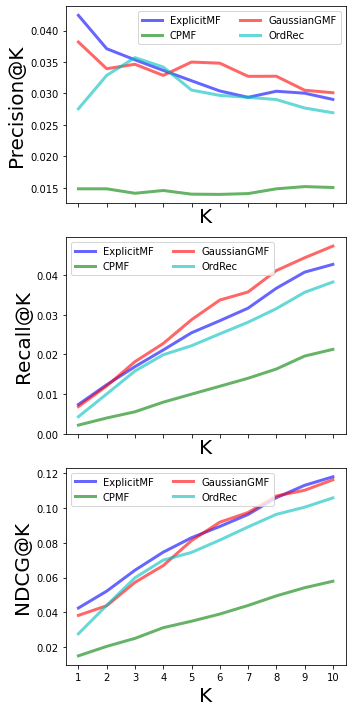

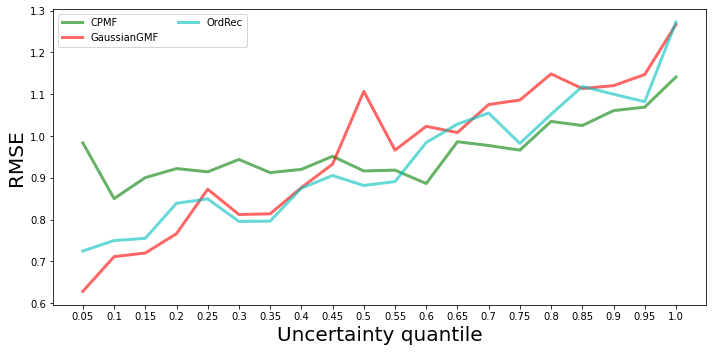

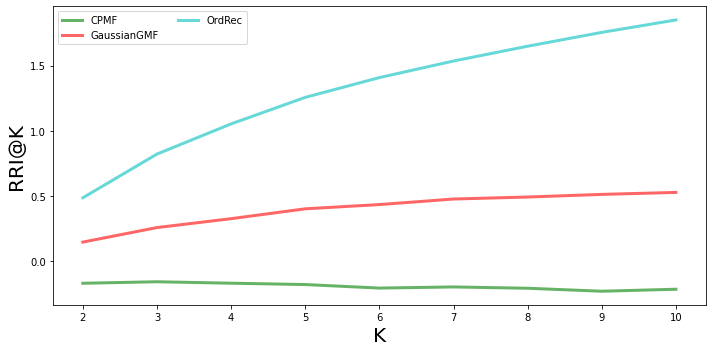

In [8]:
results_df = pd.DataFrame.from_dict(results, orient='Index')
ratings = results_df[['RMSE', 'RPI', 'Classification']]
print(ratings)

colors = [c for c in list(BASE_COLORS)]
keys = results_df.index.to_list()
colors = {keys[i]:colors[i] for i in range(len(keys))}
f, ax = plt.subplots(nrows=3, figsize=(5, 10), sharex=True)
for key in keys:
    ax[0].plot(torch.arange(1, 11), results_df['Precision'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(torch.arange(1, 11), results_df['Recall'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[2].plot(torch.arange(1, 11), results_df['NDCG'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(torch.arange(1, 11))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Precision@K', fontsize=20)
ax[0].legend(ncol=2)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Recall@K', fontsize=20)
ax[1].legend(ncol=2)
ax[2].set_xlabel('K', fontsize=20)
ax[2].set_ylabel('NDCG@K', fontsize=20)
ax[2].legend(ncol=2)
f.tight_layout()

f, ax = plt.subplots(figsize=(10, 5))
keys = ['CPMF', 'GaussianGMF', 'OrdRec']
for key in keys:
    ax.plot(torch.arange(1, 21), results_df['Quantile RMSE'][key],
            '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xticks(torch.arange(1, 21))
ax.set_xticklabels([round(elem, 2) for elem in torch.linspace(start=0.05, end=1, steps=20).tolist()])
ax.set_xlabel('Uncertainty quantile', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend(ncol=2)
f.tight_layout()

f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(torch.arange(2, 11), results_df['RRI'][key].detach(),
            '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xlabel('K', fontsize=20)
ax.set_ylabel('RRI@K', fontsize=20)
ax.legend(ncol=2)
f.tight_layout()